In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, e, m_p

%matplotlib inline
import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
sns.set_style('darkgrid', {
        'axes.linewidth': 2,
        'lines.markeredgewidth': 0,
        'legend.fancybox': True})

/usr/lib64/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Bunch creation

We create a bunch - LHC type. No fancy wrapper function available yet to produce a RF matched distribution. A little tedious because it requires quite some definitions to be done beforehand of the full RF System - but that's due to the nature of the problem.

- Some beam kinetic parameters and RF machine parameters

In [2]:
from PyHEADTAIL.trackers.rf_bucket import RFBucket
from PyHEADTAIL.particles.generators import ParticleGenerator, \
    gaussian2D, RF_bucket_distribution, StationaryExponential

PyHEADTAIL v1.7.2.1




In [3]:
momentum = 450e9 * e/c
gamma = np.sqrt((momentum/(m_p*c))**2 + 1)
beta = np.sqrt(1 - gamma**-2)

circumference = 26658.883
alpha = 3.225e-4
h1 = 35640
V1 = 8e6
p_increment = 0 * e/c * circumference/(beta*c)

print gamma

479.606062093


In [4]:
rfbucket = RFBucket(
    charge=e, mass=m_p, gamma=gamma,
    circumference=circumference,
    alpha_array=[alpha], p_increment=0,
    harmonic_list=[h1], voltage_list=[V1], phi_offset_list=[0])

In [5]:
bunch = ParticleGenerator(
    macroparticlenumber=1e5, intensity=1e11,
    charge=e, mass=m_p, gamma=gamma,
    circumference=26658.883,
    distribution_x=gaussian2D(2e-6),
    distribution_y=gaussian2D(2e-6),
    distribution_z=RF_bucket_distribution(rfbucket, epsn_z=0.35)
).generate()

*** Maximum RMS emittance 0.888689919173eV s.
... distance to target emittance: 2.32e-02
... distance to target emittance: 2.34e-02
... distance to target emittance: -5.11e-04
... distance to target emittance: 1.04e-05
--> Emittance: 0.350000004218
--> Bunch length:0.0697492609648


In [20]:
bunch2 = ParticleGenerator(
    macroparticlenumber=1e5, intensity=1e11,
    charge=e, mass=m_p, gamma=gamma,
    circumference=26658.883,
    distribution_x=gaussian2D(2e-6),
    distribution_y=gaussian2D(2e-6),
    distribution_z=RF_bucket_distribution(rfbucket, epsn_z=0.35)
).generate()

distance = 1.
bunch2.z -= distance

*** Maximum RMS emittance 0.888689919173eV s.
... distance to target emittance: 2.32e-02
... distance to target emittance: 2.34e-02
... distance to target emittance: -5.11e-04
... distance to target emittance: 1.04e-05
--> Emittance: 0.350000004218
--> Bunch length:0.0697492609648


In [21]:
# fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(6,6))
# ax1.plot(bunch.x, bunch.xp, '.')
# ax2.plot(bunch.y, bunch.yp, '.')
# ax3.plot(bunch.z, bunch.dp, '.')
# ax3.set_ylim(-max(abs(bunch.dp))-1e-4, max(abs(bunch.dp))+1e-4)
# plt.show()

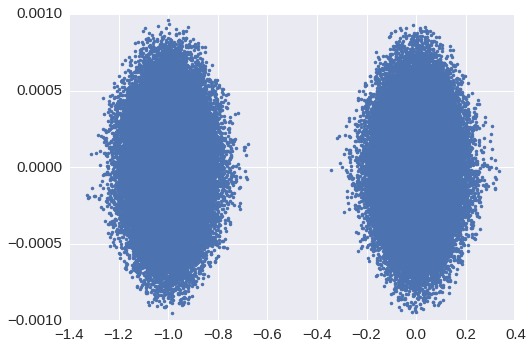

In [22]:
bunches = bunch + bunch2

plt.plot(bunches.z, bunches.dp, '.')
plt.show()

## Wakes, slicing, convolution etc.

The CircularResonator wake is a special resonator wake with Yokoya factors X1=1, Y1=1, X2=0, Y2=0

functions transverse and longitudinal are actually meant to be used internally when building the wake kicks - at this point they are concatenated with the respective Yokoya factor being applied/provided. For visualisation we can also build them externally manually.

In [23]:
from PyHEADTAIL.impedances.wakes import CircularResonator, \
    WakeField, check_wake_sampling
from PyHEADTAIL.particles.slicing import UniformBinSlicer

In [24]:
wake = CircularResonator(R_shunt=1e9, frequency=1e9, Q=20)
# slicer = UniformBinSlicer(30, z_cuts=(-.3, .3))
slicer = UniformBinSlicer(100, z_cuts=(-1.3, .3))

wakefields = WakeField(slicer, wake)
kick = wakefields.wake_kicks[0]
wf = kick.wake_function

slices = bunches.get_slices(slicer)

*** PyHEADTAIL WARNING! Acceleration not handled properly by this kind of convolution due to changing bunch length!
*** PyHEADTAIL WARNING! Acceleration not handled properly by this kind of convolution due to changing bunch length!


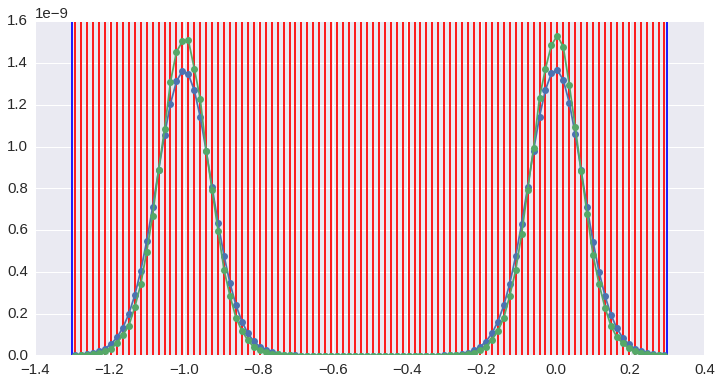

In [25]:
fig, ax = plt.subplots(1, figsize=(12,6))
[ax.axvline(s, c='r') for s in slices.z_centers]
[ax.axvline(s, c='b') for s in [slices.z_cut_tail, slices.z_cut_head]]
ax.plot(slices.z_centers, slices.lambda_bins(), '-o')
ax.plot(slices.z_centers, slices.charge_per_slice, '-o')
plt.show()

## Convolutions

### Simple Python loop

In [26]:
times = slices.z_centers / (bunch.beta*c)
delta_xp = 0.*times
for i, s in enumerate(slices.charge_per_slice):
    for j in range(slices.n_slices)[::-1]:
        delta_xp[i] += slices.charge_per_slice[j]*wf(times[i]-times[j])

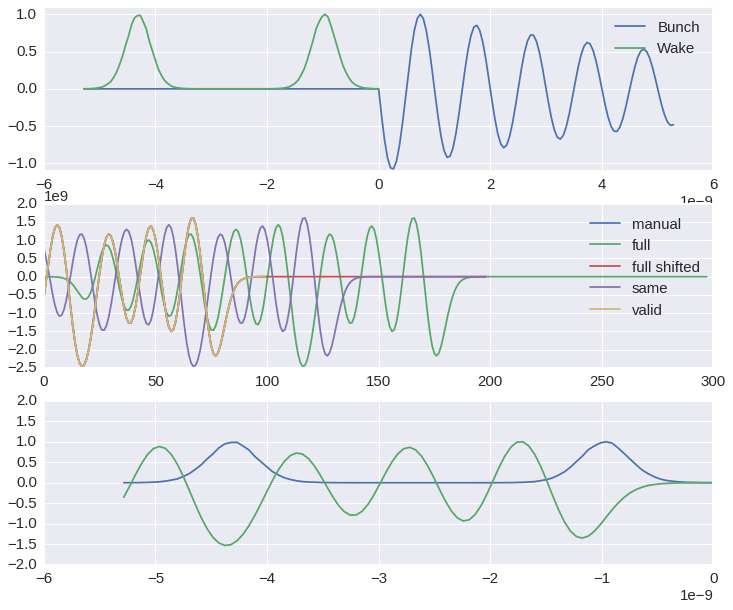

In [27]:
tt = times - times[0]
tt = np.concatenate((-tt[::-1], tt[1:]))

dxp = np.convolve(slices.charge_per_slice, wf(tt))
dxp_s = np.convolve(slices.charge_per_slice, wf(tt), mode='same')
dxp_v = np.convolve(slices.charge_per_slice, wf(tt), mode='valid')

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,10))

ax1.plot(tt, wf(tt)[::-1]/max(wf(tt)[::-1]))
ax1.plot(times-times[-1], slices.charge_per_slice/max(slices.charge_per_slice))
ax1.set_ylim((-1.1, 1.1))
ax1.legend(['Bunch', 'Wake'])
ax2.plot(delta_xp)
ax2.plot(dxp)
ax2.plot(dxp[slices.n_slices-1:])
ax2.plot(dxp_s)
ax2.plot(dxp_v)
ax2.legend(['manual', 'full', 'full shifted', 'same', 'valid'])
ax3.plot(times-times[-1], slices.charge_per_slice/max(slices.charge_per_slice))
ax3.plot(times-times[-1], dxp_v/max(dxp_v))
ax3.set_ylim(-2, 2)

plt.show()